# Task 2: Exploratory Data Analysis

**Objective:** Analyze the data to understand patterns and factors influencing financial inclusion in Ethiopia.

This notebook performs comprehensive exploratory data analysis covering:
- Dataset Overview
- Access Analysis (Account Ownership)
- Usage Analysis (Digital Payments)
- Infrastructure and Enablers
- Event Timeline and Visual Analysis
- Correlation Analysis
- Key Insights Documentation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, str(Path().resolve().parent / 'src'))

from data_loader import load_enriched_data, load_reference_codes, load_additional_data_guide

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Color palette
colors = sns.color_palette("husl", 8)

## 1. Dataset Overview

In [2]:
# Load enriched data (falls back to original if enriched doesn't exist)
main_data, impact_links = load_enriched_data()
ref_codes = load_reference_codes()
data_guide = load_additional_data_guide()

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nMain data shape: {main_data.shape}")
print(f"Impact links shape: {impact_links.shape}")
print(f"Reference codes shape: {ref_codes.shape}")

# Separate by record type
observations = main_data[main_data['record_type'] == 'observation'].copy()
events = main_data[main_data['record_type'] == 'event'].copy()
targets = main_data[main_data['record_type'] == 'target'].copy()

print(f"\nObservations: {len(observations)}")
print(f"Events: {len(events)}")
print(f"Targets: {len(targets)}")

DATASET OVERVIEW

Main data shape: (51, 34)
Impact links shape: (17, 35)
Reference codes shape: (71, 4)

Observations: 35
Events: 13
Targets: 3



1.1 RECORD TYPE DISTRIBUTION
record_type
observation    35
event          13
target          3
Name: count, dtype: int64

1.2 PILLAR DISTRIBUTION (Observations)
pillar
ACCESS           17
USAGE            12
GENDER            5
AFFORDABILITY     1
Name: count, dtype: int64

1.3 SOURCE TYPE DISTRIBUTION
source_type
survey                        11
operator                      11
research                       4
regulator                      3
calculated                     2
international_organization     2
operator_report                1
central_bank                   1
Name: count, dtype: int64


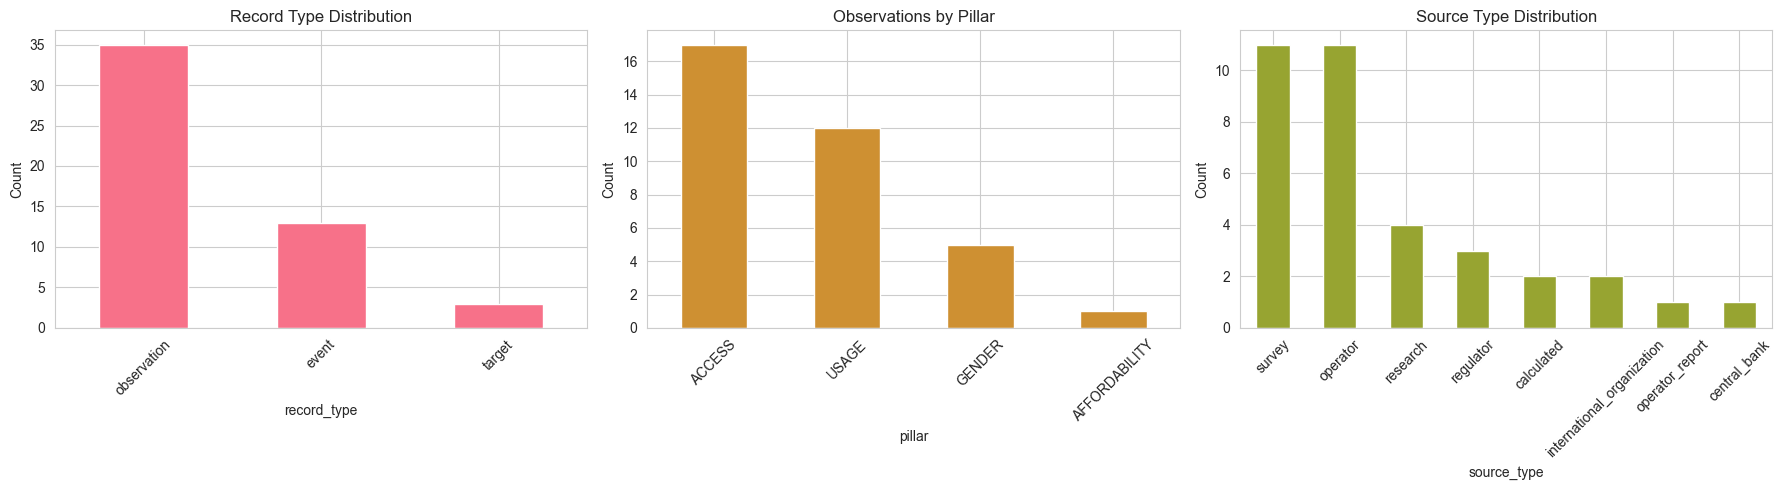

In [3]:
# 1.1 Summarize by record_type, pillar, and source_type
print("\n" + "=" * 80)
print("1.1 RECORD TYPE DISTRIBUTION")
print("=" * 80)
print(main_data['record_type'].value_counts())

print("\n" + "=" * 80)
print("1.2 PILLAR DISTRIBUTION (Observations)")
print("=" * 80)
print(observations['pillar'].value_counts())

print("\n" + "=" * 80)
print("1.3 SOURCE TYPE DISTRIBUTION")
print("=" * 80)
if 'source_type' in observations.columns:
    print(observations['source_type'].value_counts())

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

main_data['record_type'].value_counts().plot(kind='bar', ax=axes[0], color=colors[0])
axes[0].set_title('Record Type Distribution')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

observations['pillar'].value_counts().plot(kind='bar', ax=axes[1], color=colors[1])
axes[1].set_title('Observations by Pillar')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

if 'source_type' in observations.columns:
    observations['source_type'].value_counts().plot(kind='bar', ax=axes[2], color=colors[2])
    axes[2].set_title('Source Type Distribution')
    axes[2].set_ylabel('Count')
    axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


1.4 TEMPORAL COVERAGE


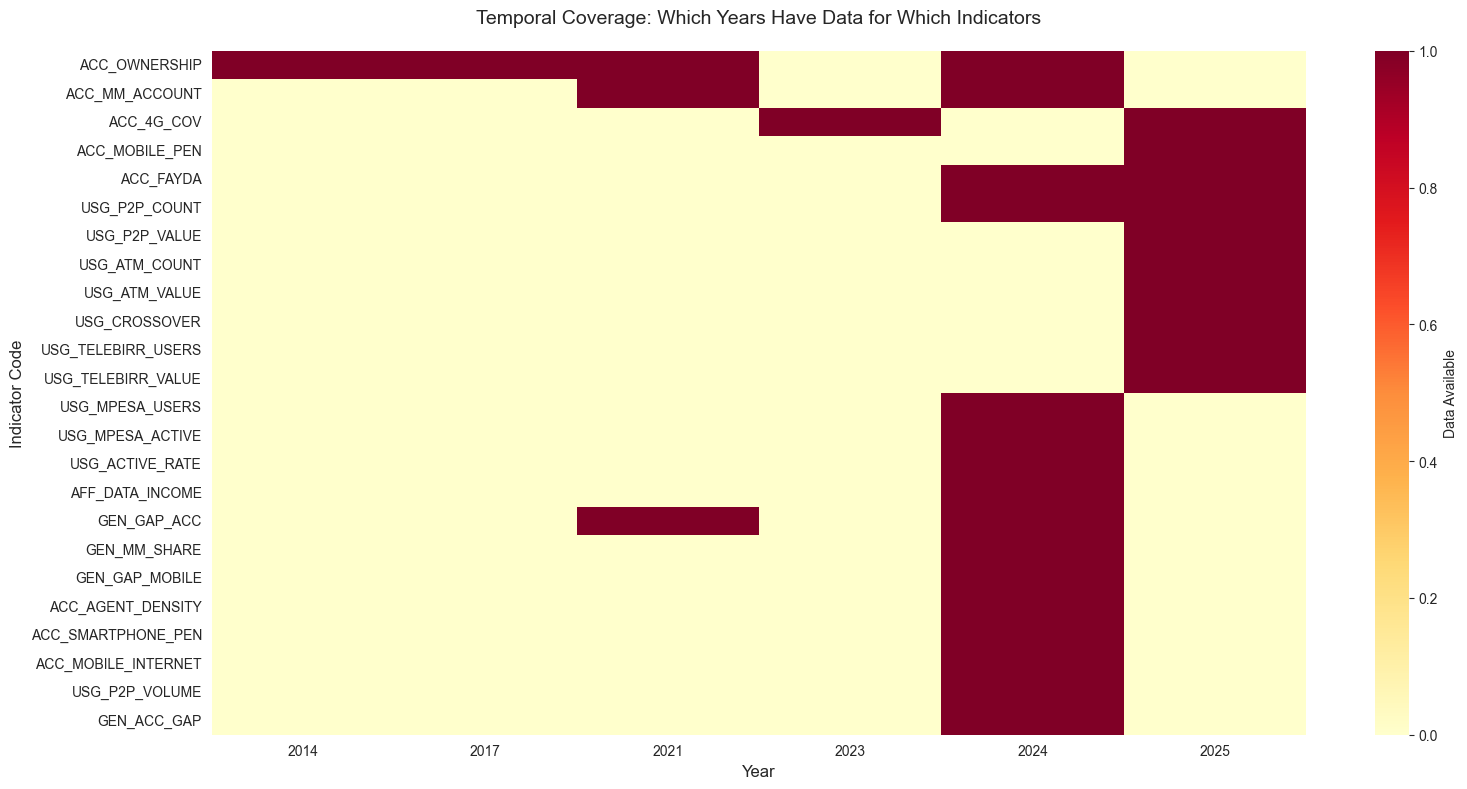


Total indicators: 24
Years covered: [np.int32(2014), np.int32(2017), np.int32(2021), np.int32(2023), np.int32(2024), np.int32(2025)]

Indicators with most coverage:
ACC_OWNERSHIP     4
ACC_MM_ACCOUNT    2
ACC_4G_COV        2
ACC_FAYDA         2
USG_P2P_COUNT     2
GEN_GAP_ACC       2
USG_P2P_VALUE     1
ACC_MOBILE_PEN    1
USG_ATM_COUNT     1
USG_ATM_VALUE     1
dtype: int64


In [4]:
# 1.4 Temporal Coverage Visualization
print("\n" + "=" * 80)
print("1.4 TEMPORAL COVERAGE")
print("=" * 80)

# Prepare data for temporal coverage
observations['date'] = pd.to_datetime(observations['observation_date'], errors='coerce')
observations['year'] = observations['date'].dt.year

# Get unique indicators and years
indicators = observations['indicator_code'].dropna().unique()
years = sorted(observations['year'].dropna().unique())

# Create coverage matrix
coverage_matrix = pd.DataFrame(index=indicators, columns=years)
for idx, row in observations.iterrows():
    if pd.notna(row['indicator_code']) and pd.notna(row['year']):
        coverage_matrix.loc[row['indicator_code'], row['year']] = 1

coverage_matrix = coverage_matrix.fillna(0)

# Visualize
plt.figure(figsize=(16, max(8, len(indicators) * 0.3)))
sns.heatmap(coverage_matrix.astype(int), annot=False, cmap='YlOrRd', cbar_kws={'label': 'Data Available'}, 
            yticklabels=True, xticklabels=True)
plt.title('Temporal Coverage: Which Years Have Data for Which Indicators', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Indicator Code', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nTotal indicators: {len(indicators)}")
print(f"Years covered: {years}")
print(f"\nIndicators with most coverage:")
coverage_counts = coverage_matrix.sum(axis=1).sort_values(ascending=False)
print(coverage_counts.head(10))


1.5 DATA QUALITY - CONFIDENCE LEVELS
confidence
high      31
medium     4
Name: count, dtype: int64


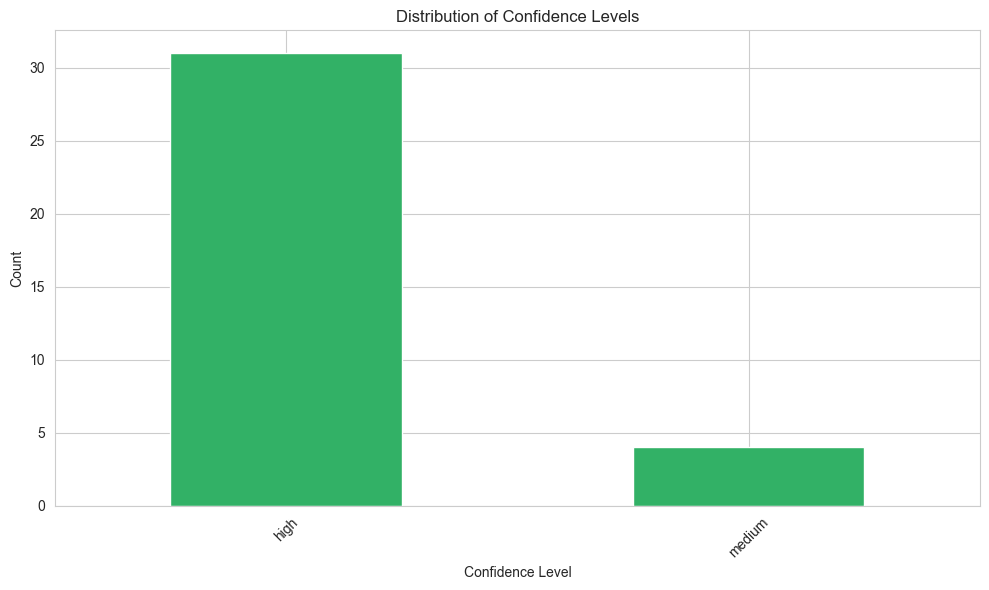


Confidence by Pillar:
confidence     high  medium
pillar                     
ACCESS           16       1
AFFORDABILITY     0       1
GENDER            4       1
USAGE            11       1


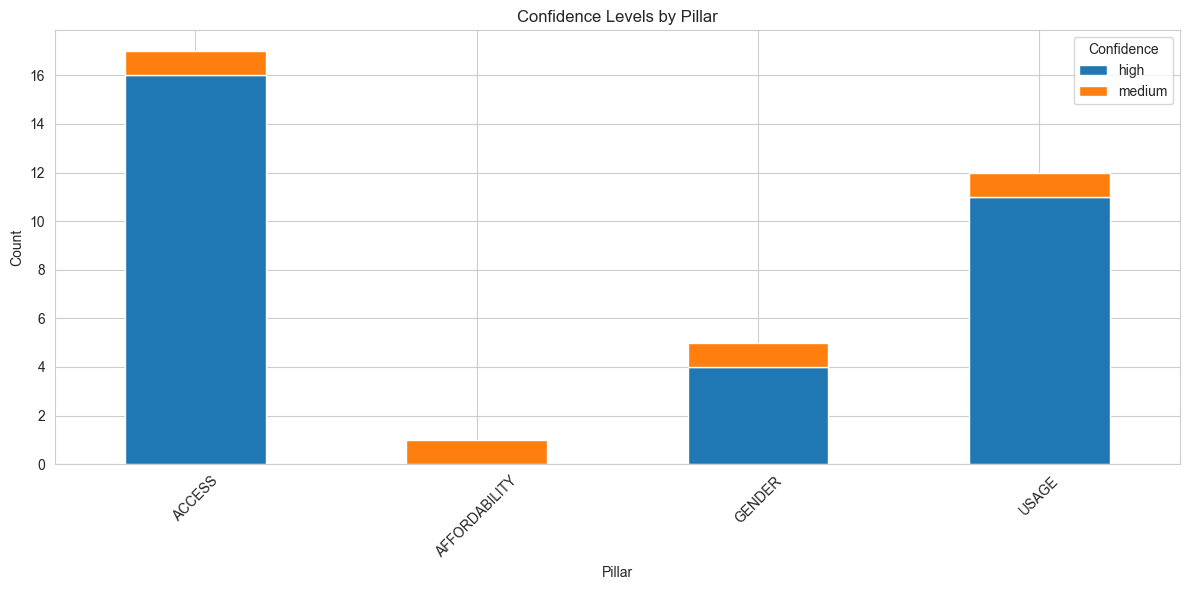

In [5]:
# 1.5 Data Quality: Confidence Levels
print("\n" + "=" * 80)
print("1.5 DATA QUALITY - CONFIDENCE LEVELS")
print("=" * 80)

if 'confidence' in observations.columns:
    conf_dist = observations['confidence'].value_counts()
    print(conf_dist)
    
    plt.figure(figsize=(10, 6))
    conf_dist.plot(kind='bar', color=colors[3])
    plt.title('Distribution of Confidence Levels')
    plt.ylabel('Count')
    plt.xlabel('Confidence Level')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Confidence by pillar
    if 'pillar' in observations.columns:
        conf_by_pillar = pd.crosstab(observations['pillar'], observations['confidence'])
        print("\nConfidence by Pillar:")
        print(conf_by_pillar)
        
        conf_by_pillar.plot(kind='bar', stacked=True, figsize=(12, 6))
        plt.title('Confidence Levels by Pillar')
        plt.ylabel('Count')
        plt.xlabel('Pillar')
        plt.xticks(rotation=45)
        plt.legend(title='Confidence')
        plt.tight_layout()
        plt.show()

In [6]:
# 1.6 Identify Data Gaps
print("\n" + "=" * 80)
print("1.6 DATA GAPS ANALYSIS")
print("=" * 80)

# Indicators with sparse coverage (only 1-2 data points)
sparse_indicators = coverage_counts[coverage_counts <= 2]
print(f"\nIndicators with sparse coverage (≤2 data points): {len(sparse_indicators)}")
print(sparse_indicators)

# Missing years in Findex surveys (should be every 3 years: 2011, 2014, 2017, 2021, 2024)
findex_years = [2011, 2014, 2017, 2021, 2024]
acc_ownership_years = observations[
    (observations['indicator_code'] == 'ACC_OWNERSHIP') & 
    (observations['year'].notna())
]['year'].unique()

missing_findex = [y for y in findex_years if y not in acc_ownership_years]
if missing_findex:
    print(f"\nMissing Findex survey years: {missing_findex}")
else:
    print("\nAll expected Findex survey years are present")

# Check for gender disaggregation
gender_obs = observations[observations['gender'].notna() & (observations['gender'] != 'all')]
print(f"\nGender-disaggregated observations: {len(gender_obs)}")

# Check for location disaggregation
location_obs = observations[observations['location'].notna() & (observations['location'] != 'national')]
print(f"Location-disaggregated observations: {len(location_obs)}")


1.6 DATA GAPS ANALYSIS

Indicators with sparse coverage (≤2 data points): 23
ACC_MM_ACCOUNT         2
ACC_4G_COV             2
ACC_FAYDA              2
USG_P2P_COUNT          2
GEN_GAP_ACC            2
USG_P2P_VALUE          1
ACC_MOBILE_PEN         1
USG_ATM_COUNT          1
USG_ATM_VALUE          1
USG_TELEBIRR_USERS     1
USG_CROSSOVER          1
USG_MPESA_USERS        1
USG_MPESA_ACTIVE       1
USG_ACTIVE_RATE        1
USG_TELEBIRR_VALUE     1
AFF_DATA_INCOME        1
GEN_MM_SHARE           1
GEN_GAP_MOBILE         1
ACC_AGENT_DENSITY      1
ACC_SMARTPHONE_PEN     1
ACC_MOBILE_INTERNET    1
USG_P2P_VOLUME         1
GEN_ACC_GAP            1
dtype: int64

Missing Findex survey years: [2011]

Gender-disaggregated observations: 4
Location-disaggregated observations: 0


## 2. Access Analysis - Account Ownership

2. ACCESS ANALYSIS - ACCOUNT OWNERSHIP

Account Ownership Timeline:
 year  value_numeric        source_name
 2014           22.0 Global Findex 2014
 2017           35.0 Global Findex 2017
 2021           46.0 Global Findex 2021
 2021           56.0 Global Findex 2021
 2021           36.0 Global Findex 2021
 2024           49.0 Global Findex 2024


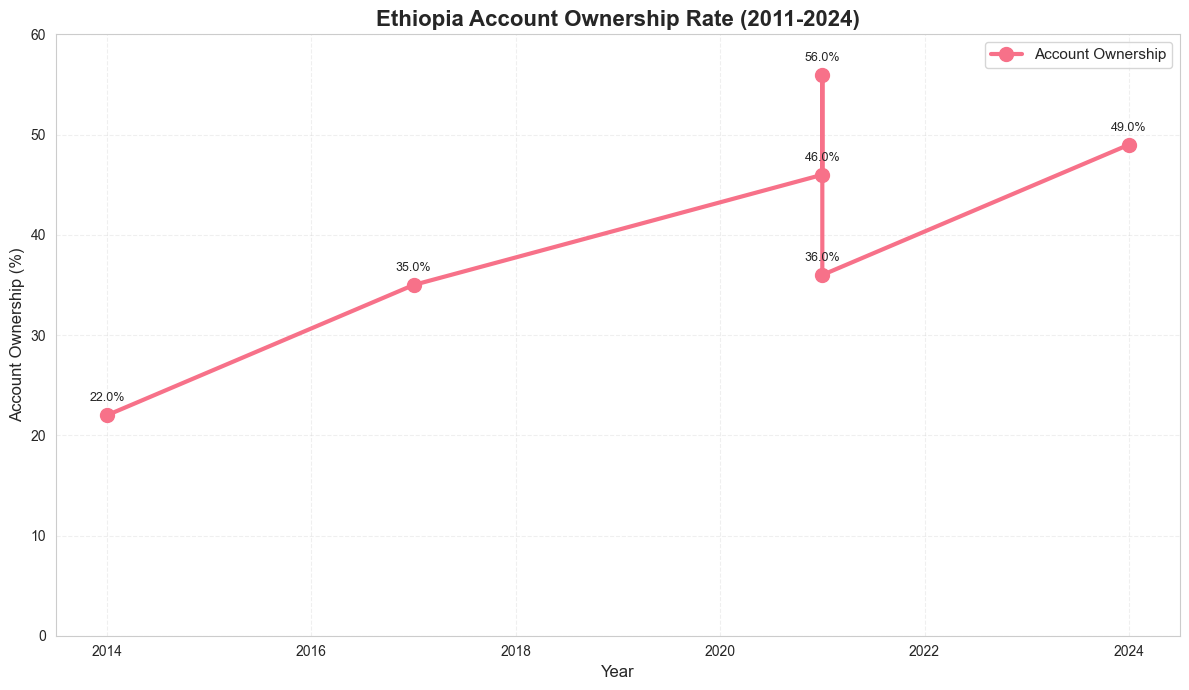


Historical Account Ownership (from project description):
 year  account_ownership  change
 2011                 14     NaN
 2014                 22     8.0
 2017                 35    13.0
 2021                 46    11.0
 2024                 49     3.0


In [7]:
# 2.1 Account Ownership Trajectory (2011-2024)
print("=" * 80)
print("2. ACCESS ANALYSIS - ACCOUNT OWNERSHIP")
print("=" * 80)

# Get account ownership data
acc_ownership = observations[
    (observations['indicator_code'] == 'ACC_OWNERSHIP') & 
    (observations['value_numeric'].notna())
].copy()

acc_ownership = acc_ownership.sort_values('year')
acc_ownership['year'] = acc_ownership['year'].astype(int)

print("\nAccount Ownership Timeline:")
print(acc_ownership[['year', 'value_numeric', 'source_name']].to_string(index=False))

# Plot trajectory
plt.figure(figsize=(12, 7))
plt.plot(acc_ownership['year'], acc_ownership['value_numeric'], 
         marker='o', linewidth=3, markersize=10, color=colors[0], label='Account Ownership')
plt.title('Ethiopia Account Ownership Rate (2011-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Account Ownership (%)', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(0, 60)

# Add value labels
for _, row in acc_ownership.iterrows():
    plt.annotate(f"{row['value_numeric']:.1f}%", 
                (row['year'], row['value_numeric']),
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Historical trajectory from project description
historical = pd.DataFrame({
    'year': [2011, 2014, 2017, 2021, 2024],
    'account_ownership': [14, 22, 35, 46, 49],
    'change': [None, 8, 13, 11, 3]
})

print("\nHistorical Account Ownership (from project description):")
print(historical.to_string(index=False))


2.2 GROWTH RATES BETWEEN SURVEY YEARS

Growth Analysis:
     Period  Years  Growth (pp)  Growth (%)
2014-2017.0    3.0          8.0        57.1
2017-2021.0    3.0         13.0        59.1
2021-2024.0    4.0         11.0        31.4
   2024-nan    3.0          3.0         6.5


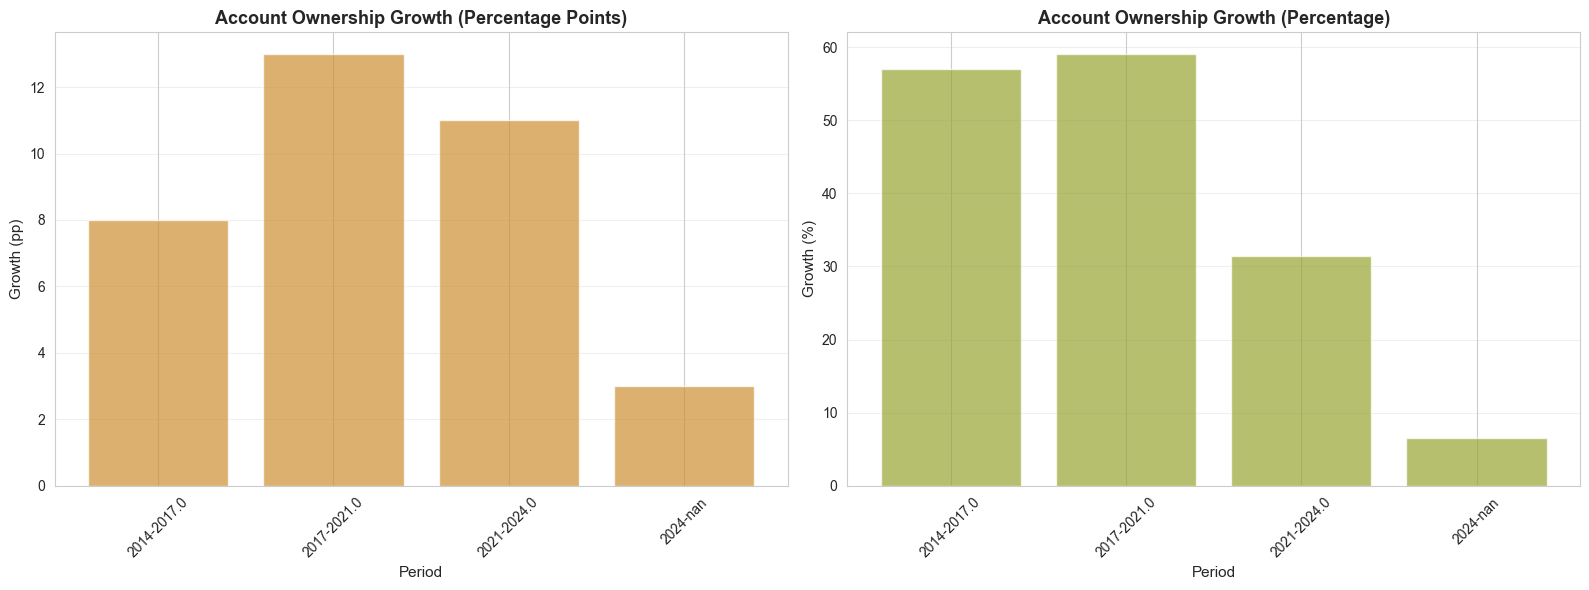


⚠️ KEY OBSERVATION: Growth slowed dramatically in 2021-2024 (+3pp) vs 2017-2021 (+11pp)
   Despite massive mobile money expansion (65M+ accounts), account ownership only grew 3pp


In [8]:
# 2.2 Calculate Growth Rates
print("\n" + "=" * 80)
print("2.2 GROWTH RATES BETWEEN SURVEY YEARS")
print("=" * 80)

# Calculate period-over-period growth
historical['period'] = historical['year'].astype(str) + '-' + historical['year'].shift(-1).astype(str)
historical['growth_pp'] = historical['account_ownership'].diff()
historical['growth_pct'] = (historical['account_ownership'].pct_change() * 100).round(1)
historical['years'] = historical['year'].diff()

print("\nGrowth Analysis:")
growth_df = historical[['period', 'years', 'growth_pp', 'growth_pct']].dropna()
growth_df.columns = ['Period', 'Years', 'Growth (pp)', 'Growth (%)']
print(growth_df.to_string(index=False))

# Visualize growth rates
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute growth (percentage points)
axes[0].bar(growth_df['Period'], growth_df['Growth (pp)'], color=colors[1], alpha=0.7)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_title('Account Ownership Growth (Percentage Points)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Growth (pp)', fontsize=11)
axes[0].set_xlabel('Period', fontsize=11)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Percentage growth
axes[1].bar(growth_df['Period'], growth_df['Growth (%)'], color=colors[2], alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_title('Account Ownership Growth (Percentage)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Growth (%)', fontsize=11)
axes[1].set_xlabel('Period', fontsize=11)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n⚠️ KEY OBSERVATION: Growth slowed dramatically in 2021-2024 (+3pp) vs 2017-2021 (+11pp)")
print(f"   Despite massive mobile money expansion (65M+ accounts), account ownership only grew 3pp")


2.3 GENDER GAP ANALYSIS

Gender-disaggregated account ownership data found: 2 records
 year gender  value_numeric
 2021   male           56.0
 2021 female           36.0


<Figure size 1200x600 with 0 Axes>

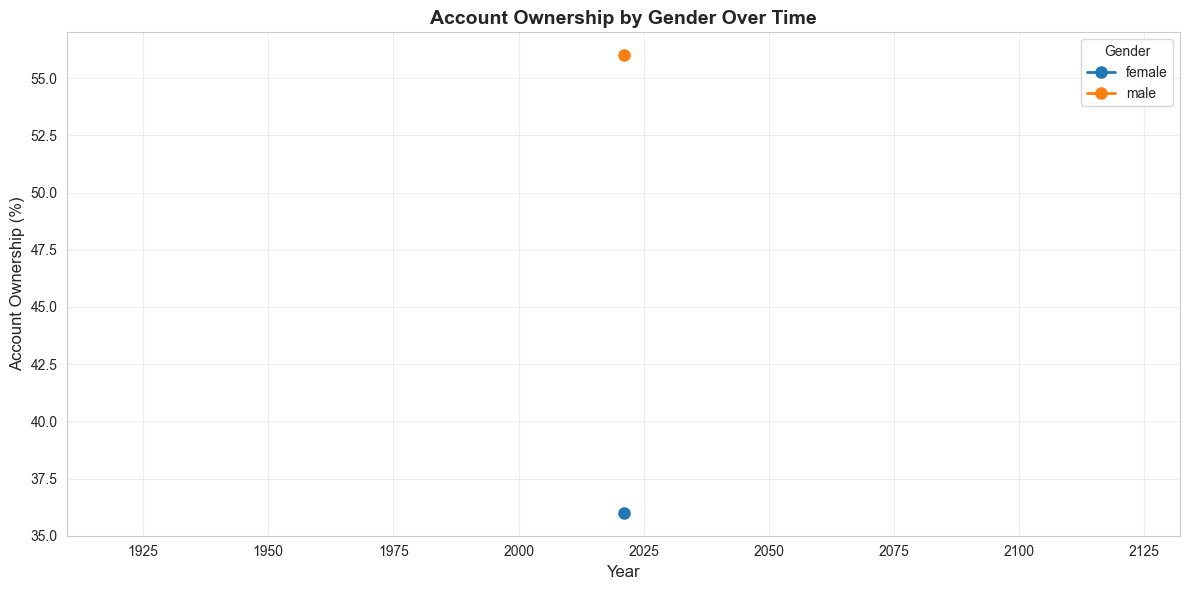


Gender Gap (Male - Female):
gender  male  female   gap
year                      
2021    56.0    36.0  20.0


In [9]:
# 2.3 Gender Gap Analysis
print("\n" + "=" * 80)
print("2.3 GENDER GAP ANALYSIS")
print("=" * 80)

# Check for gender-disaggregated data
gender_acc = observations[
    (observations['indicator_code'] == 'ACC_OWNERSHIP') & 
    (observations['gender'].notna()) &
    (observations['gender'] != 'all') &
    (observations['value_numeric'].notna())
]

if len(gender_acc) > 0:
    print(f"\nGender-disaggregated account ownership data found: {len(gender_acc)} records")
    print(gender_acc[['year', 'gender', 'value_numeric']].to_string(index=False))
    
    # Visualize if we have data
    if len(gender_acc) >= 2:
        gender_pivot = gender_acc.pivot_table(
            index='year', 
            columns='gender', 
            values='value_numeric'
        )
        
        plt.figure(figsize=(12, 6))
        gender_pivot.plot(kind='line', marker='o', linewidth=2, markersize=8, figsize=(12, 6))
        plt.title('Account Ownership by Gender Over Time', fontsize=14, fontweight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Account Ownership (%)', fontsize=12)
        plt.legend(title='Gender', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Calculate gender gap
        if 'male' in gender_pivot.columns and 'female' in gender_pivot.columns:
            gender_pivot['gap'] = gender_pivot['male'] - gender_pivot['female']
            print("\nGender Gap (Male - Female):")
            print(gender_pivot[['male', 'female', 'gap']].to_string())
else:
    # Check for gender gap indicator
    gender_gap = observations[
        (observations['indicator_code'] == 'GEN_ACC_GAP') &
        (observations['value_numeric'].notna())
    ]
    
    if len(gender_gap) > 0:
        print(f"\nGender gap indicator found: {len(gender_gap)} records")
        print(gender_gap[['year', 'value_numeric', 'notes']].to_string(index=False))
        
        plt.figure(figsize=(10, 6))
        plt.bar(gender_gap['year'].astype(str), gender_gap['value_numeric'], color=colors[4])
        plt.title('Gender Gap in Account Ownership Over Time', fontsize=14, fontweight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Gender Gap (pp)', fontsize=12)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    else:
        print("\n⚠️ No gender-disaggregated data available in dataset")
        print("   Gender gap analysis limited by data availability")

In [10]:
# 2.4 Urban vs Rural Analysis
print("\n" + "=" * 80)
print("2.4 URBAN VS RURAL ANALYSIS")
print("=" * 80)

location_acc = observations[
    (observations['indicator_code'] == 'ACC_OWNERSHIP') & 
    (observations['location'].notna()) &
    (observations['location'] != 'national') &
    (observations['value_numeric'].notna())
]

if len(location_acc) > 0:
    print(f"\nLocation-disaggregated account ownership data found: {len(location_acc)} records")
    print(location_acc[['year', 'location', 'value_numeric']].to_string(index=False))
    
    location_pivot = location_acc.pivot_table(
        index='year', 
        columns='location', 
        values='value_numeric'
    )
    
    plt.figure(figsize=(12, 6))
    location_pivot.plot(kind='line', marker='o', linewidth=2, markersize=8)
    plt.title('Account Ownership by Location Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Account Ownership (%)', fontsize=12)
    plt.legend(title='Location', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ No urban/rural disaggregated data available")


2.4 URBAN VS RURAL ANALYSIS

⚠️ No urban/rural disaggregated data available



2.5 INVESTIGATING THE 2021-2024 SLOWDOWN

🔍 Key Question: Why did account ownership grow only +3pp (2021-2024) despite:
   - Telebirr launch (May 2021) → 54M+ users
   - M-Pesa entry (Aug 2023) → 10M+ users
   - P2P transactions surpassing ATM withdrawals

📊 Mobile Money Account Penetration:
 year  value_numeric        source_name
 2021           4.70 Global Findex 2021
 2024           9.45 Global Findex 2024


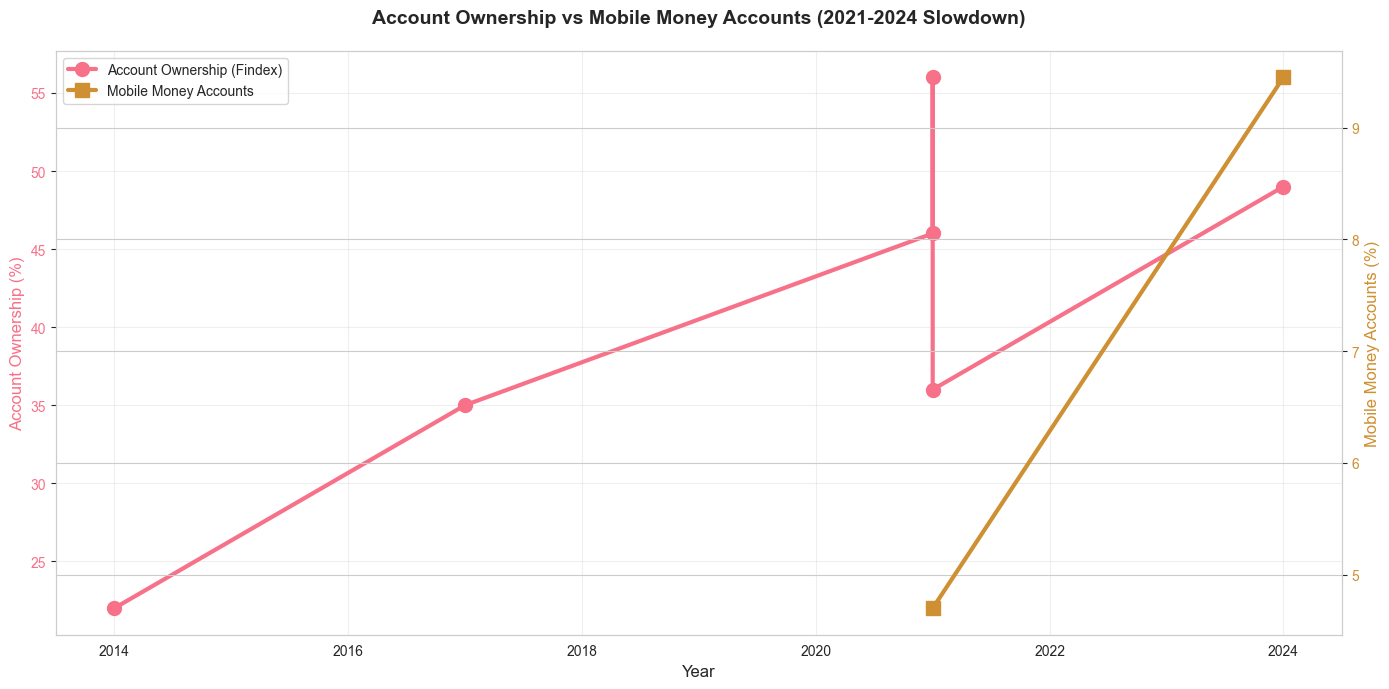


💡 Potential Explanations for Slowdown:
   1. Registered vs. Active Gap: Many mobile money accounts may be inactive
   2. Survey Methodology: Findex asks about 'using in past 12 months'
   3. Multiple Accounts: Same person may have multiple mobile money accounts
   4. Bank Account Saturation: Easy bank account access may limit mobile money adoption
   5. Usage vs. Access: Accounts exist but aren't being used (USAGE issue, not ACCESS)


In [11]:
# 2.5 Investigating the 2021-2024 Slowdown
print("\n" + "=" * 80)
print("2.5 INVESTIGATING THE 2021-2024 SLOWDOWN")
print("=" * 80)

print("\n🔍 Key Question: Why did account ownership grow only +3pp (2021-2024) despite:")
print("   - Telebirr launch (May 2021) → 54M+ users")
print("   - M-Pesa entry (Aug 2023) → 10M+ users")
print("   - P2P transactions surpassing ATM withdrawals")

# Get mobile money account data
mm_accounts = observations[
    (observations['indicator_code'] == 'ACC_MM_ACCOUNT') &
    (observations['value_numeric'].notna())
].sort_values('year')

if len(mm_accounts) > 0:
    print("\n📊 Mobile Money Account Penetration:")
    print(mm_accounts[['year', 'value_numeric', 'source_name']].to_string(index=False))
    
    # Compare account ownership vs mobile money accounts
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Account Ownership (%)', color=colors[0], fontsize=12)
    line1 = ax1.plot(acc_ownership['year'], acc_ownership['value_numeric'], 
                     marker='o', linewidth=3, markersize=10, color=colors[0], 
                     label='Account Ownership (Findex)')
    ax1.tick_params(axis='y', labelcolor=colors[0])
    ax1.grid(True, alpha=0.3)
    
    if len(mm_accounts) > 0:
        ax2 = ax1.twinx()
        ax2.set_ylabel('Mobile Money Accounts (%)', color=colors[1], fontsize=12)
        line2 = ax2.plot(mm_accounts['year'], mm_accounts['value_numeric'], 
                        marker='s', linewidth=3, markersize=10, color=colors[1], 
                        label='Mobile Money Accounts')
        ax2.tick_params(axis='y', labelcolor=colors[1])
    
    plt.title('Account Ownership vs Mobile Money Accounts (2021-2024 Slowdown)', 
              fontsize=14, fontweight='bold', pad=20)
    
    # Combine legends
    lines = line1 + (line2 if len(mm_accounts) > 0 else [])
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()

print("\n💡 Potential Explanations for Slowdown:")
print("   1. Registered vs. Active Gap: Many mobile money accounts may be inactive")
print("   2. Survey Methodology: Findex asks about 'using in past 12 months'")
print("   3. Multiple Accounts: Same person may have multiple mobile money accounts")
print("   4. Bank Account Saturation: Easy bank account access may limit mobile money adoption")
print("   5. Usage vs. Access: Accounts exist but aren't being used (USAGE issue, not ACCESS)")

## 3. Usage (Digital Payments) Analysis

3. USAGE ANALYSIS - DIGITAL PAYMENTS

Usage-related observations: 12

Usage Indicators:
indicator_code
USG_P2P_COUNT         2
USG_P2P_VALUE         1
USG_ATM_COUNT         1
USG_ATM_VALUE         1
USG_CROSSOVER         1
USG_TELEBIRR_USERS    1
USG_TELEBIRR_VALUE    1
USG_MPESA_USERS       1
USG_MPESA_ACTIVE      1
USG_ACTIVE_RATE       1
USG_P2P_VOLUME        1
Name: count, dtype: int64

📊 Mobile Money Account Penetration (2014-2024):
 year  value_numeric        source_name
 2021           4.70 Global Findex 2021
 2024           9.45 Global Findex 2024


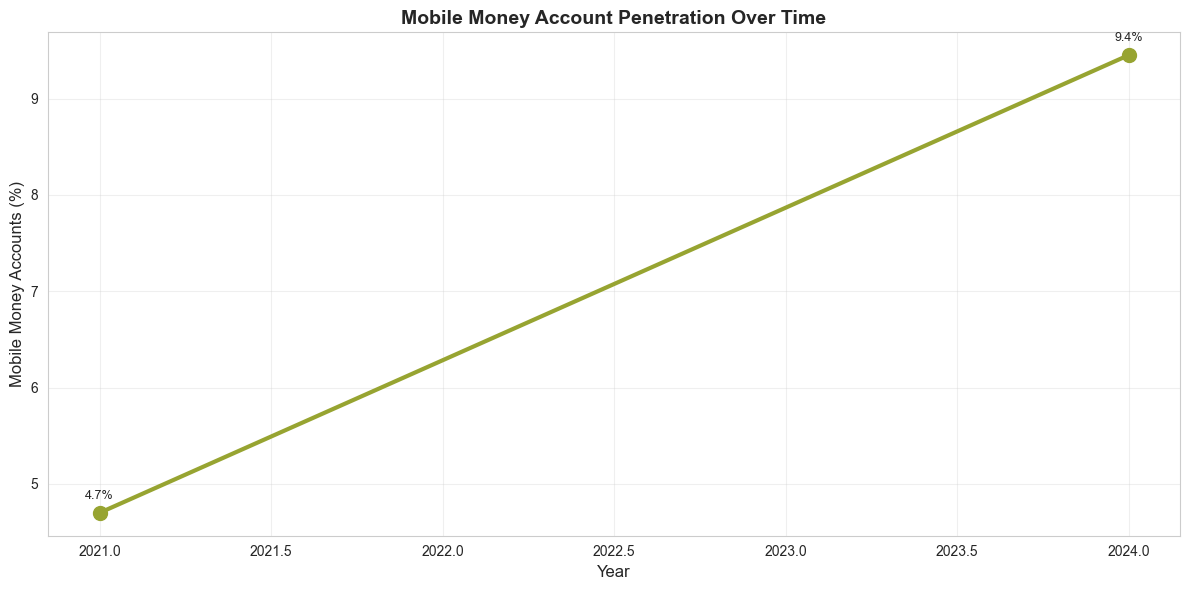

In [12]:
# 3.1 Mobile Money Account Penetration Trend
print("=" * 80)
print("3. USAGE ANALYSIS - DIGITAL PAYMENTS")
print("=" * 80)

# Get all usage-related indicators
usage_indicators = observations[
    (observations['pillar'] == 'USAGE') &
    (observations['value_numeric'].notna())
].copy()

print(f"\nUsage-related observations: {len(usage_indicators)}")
print("\nUsage Indicators:")
print(usage_indicators['indicator_code'].value_counts())

# Mobile money account penetration
mm_account = observations[
    (observations['indicator_code'] == 'ACC_MM_ACCOUNT') &
    (observations['value_numeric'].notna())
].sort_values('year')

if len(mm_account) > 0:
    print("\n📊 Mobile Money Account Penetration (2014-2024):")
    print(mm_account[['year', 'value_numeric', 'source_name']].to_string(index=False))
    
    plt.figure(figsize=(12, 6))
    plt.plot(mm_account['year'], mm_account['value_numeric'], 
             marker='o', linewidth=3, markersize=10, color=colors[2])
    plt.title('Mobile Money Account Penetration Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Mobile Money Accounts (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    for _, row in mm_account.iterrows():
        plt.annotate(f"{row['value_numeric']:.1f}%", 
                    (row['year'], row['value_numeric']),
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Limited mobile money account data available")


3.2 DIGITAL PAYMENT ADOPTION PATTERNS

Digital payment indicators found: 2


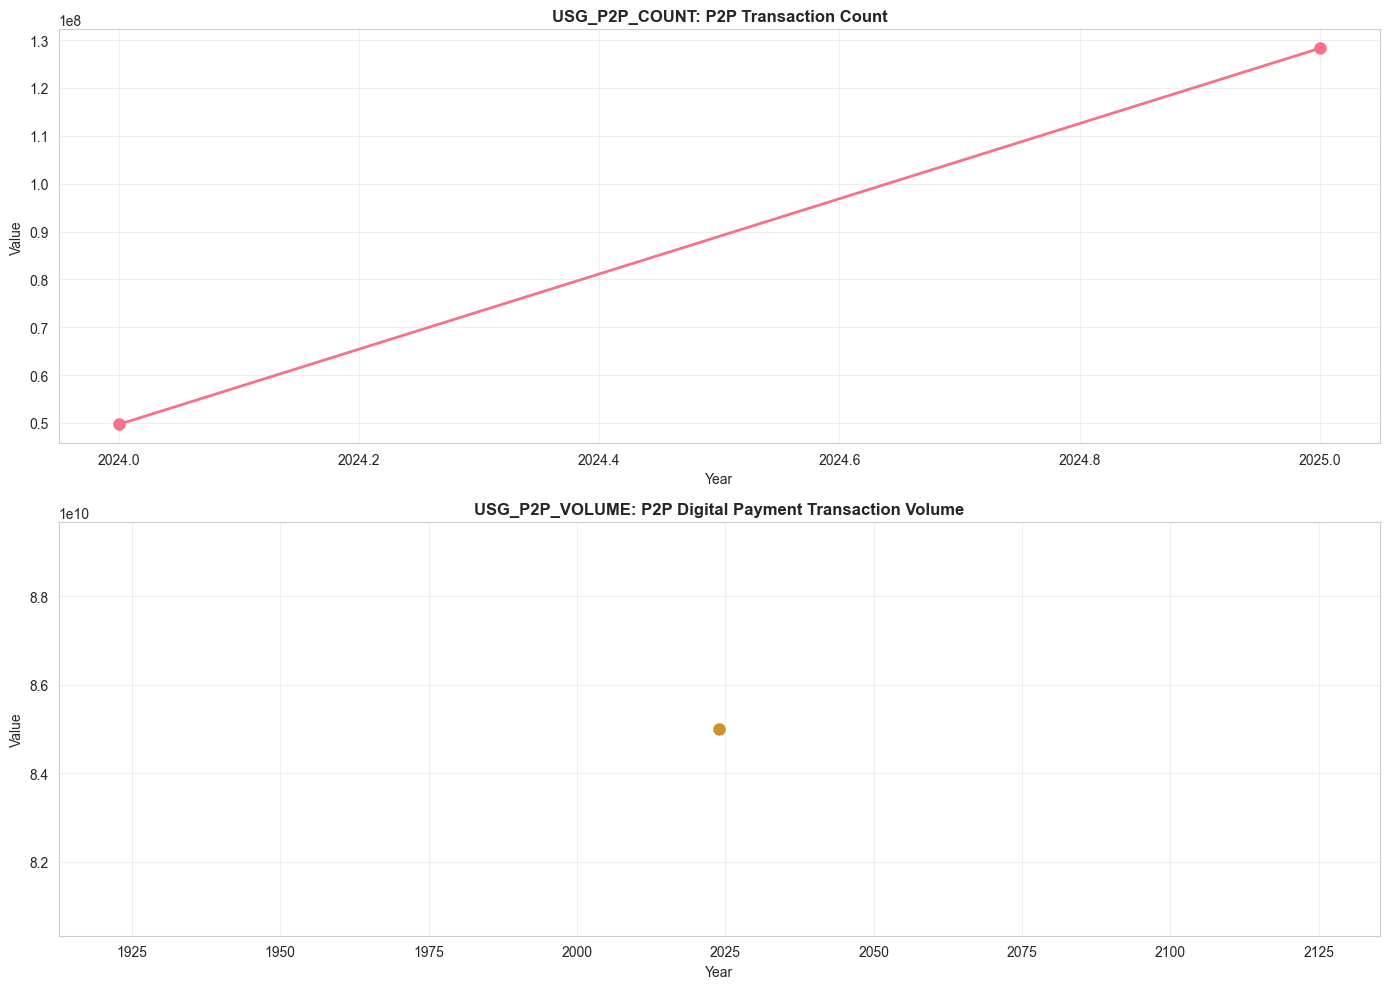


Digital Payment Indicators Summary:

USG_P2P_COUNT:
 year  value_numeric         unit
 2024     49700000.0 transactions
 2025    128300000.0 transactions

USG_P2P_VOLUME:
 year  value_numeric unit
 2024   8.500000e+10  ETB


In [13]:
# 3.2 Digital Payment Adoption Patterns
print("\n" + "=" * 80)
print("3.2 DIGITAL PAYMENT ADOPTION PATTERNS")
print("=" * 80)

# Get digital payment indicators
digital_payment_indicators = ['USG_P2P_COUNT', 'USG_P2P_VOLUME', 'USG_POS_PAYMENT', 
                              'USG_BILL_PAY', 'USG_WAGE_RECEIPT']

payment_data = {}
for indicator in digital_payment_indicators:
    data = observations[
        (observations['indicator_code'] == indicator) &
        (observations['value_numeric'].notna())
    ]
    if len(data) > 0:
        payment_data[indicator] = data.sort_values('year')

if payment_data:
    print(f"\nDigital payment indicators found: {len(payment_data)}")
    
    # Visualize all payment indicators
    fig, axes = plt.subplots(len(payment_data), 1, figsize=(14, 5*len(payment_data)))
    if len(payment_data) == 1:
        axes = [axes]
    
    for idx, (indicator, data) in enumerate(payment_data.items()):
        axes[idx].plot(data['year'], data['value_numeric'], 
                      marker='o', linewidth=2, markersize=8, color=colors[idx % len(colors)])
        axes[idx].set_title(f'{indicator}: {data["indicator"].iloc[0]}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Year', fontsize=10)
        axes[idx].set_ylabel('Value', fontsize=10)
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print("\nDigital Payment Indicators Summary:")
    for indicator, data in payment_data.items():
        print(f"\n{indicator}:")
        print(data[['year', 'value_numeric', 'unit']].to_string(index=False))
else:
    print("\n⚠️ Limited digital payment adoption data available")
    print("   Available usage indicators:")
    usage_codes = usage_indicators['indicator_code'].unique()
    for code in usage_codes:
        print(f"   - {code}")


3.3 REGISTERED VS. ACTIVE GAP

📊 Registered vs. Active Gap Analysis (2024):
   Total adult population (est.): 70,000,000
   Registered mobile money accounts: 65,000,000
   Findex account ownership (49%): 34,300,000 adults
   Gap (registered - active): 30,700,000 accounts
   Gap as % of registered: 47.2%

💡 Interpretation:
   - Large gap suggests many registered accounts are inactive
   - Multiple accounts per person (same person registered on multiple platforms)
   - Accounts opened but not used in past 12 months (Findex criteria)
   - This explains the ACCESS/USAGE disconnect


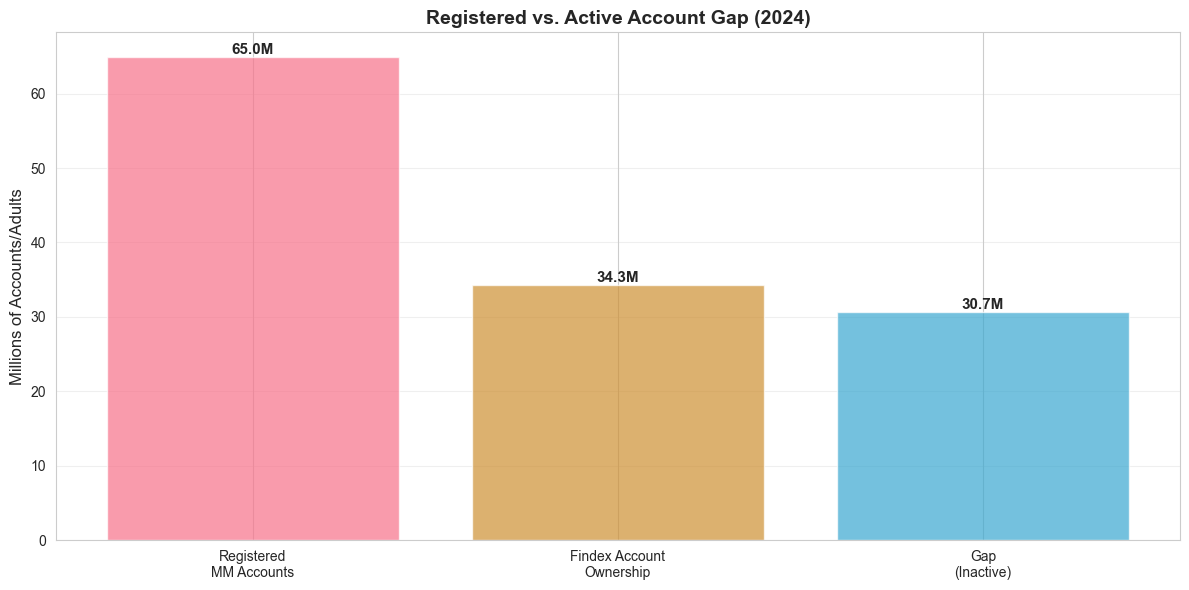

In [14]:
# 3.3 Registered vs. Active Gap Analysis
print("\n" + "=" * 80)
print("3.3 REGISTERED VS. ACTIVE GAP")
print("=" * 80)

# Compare registered accounts vs. survey-reported usage
# From project description: 65M+ mobile money accounts but only 49% account ownership

# Estimated numbers (2024)
total_adults_ethiopia = 70_000_000  # Approximate
registered_mm_accounts = 65_000_000  # From project description
findex_account_ownership = 0.49  # 49%

estimated_adults_with_accounts = total_adults_ethiopia * findex_account_ownership
gap = registered_mm_accounts - estimated_adults_with_accounts

print(f"\n📊 Registered vs. Active Gap Analysis (2024):")
print(f"   Total adult population (est.): {total_adults_ethiopia:,}")
print(f"   Registered mobile money accounts: {registered_mm_accounts:,}")
print(f"   Findex account ownership (49%): {estimated_adults_with_accounts:,.0f} adults")
print(f"   Gap (registered - active): {gap:,.0f} accounts")
print(f"   Gap as % of registered: {(gap/registered_mm_accounts)*100:.1f}%")

print("\n💡 Interpretation:")
print("   - Large gap suggests many registered accounts are inactive")
print("   - Multiple accounts per person (same person registered on multiple platforms)")
print("   - Accounts opened but not used in past 12 months (Findex criteria)")
print("   - This explains the ACCESS/USAGE disconnect")

# Visualize the gap
fig, ax = plt.subplots(figsize=(12, 6))
categories = ['Registered\nMM Accounts', 'Findex Account\nOwnership', 'Gap\n(Inactive)']
values = [registered_mm_accounts/1e6, estimated_adults_with_accounts/1e6, gap/1e6]
colors_gap = [colors[0], colors[1], colors[5]]

bars = ax.bar(categories, values, color=colors_gap, alpha=0.7)
ax.set_ylabel('Millions of Accounts/Adults', fontsize=12)
ax.set_title('Registered vs. Active Account Gap (2024)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}M',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Infrastructure and Enablers Analysis

4. INFRASTRUCTURE AND ENABLERS ANALYSIS

Infrastructure indicators found: 6


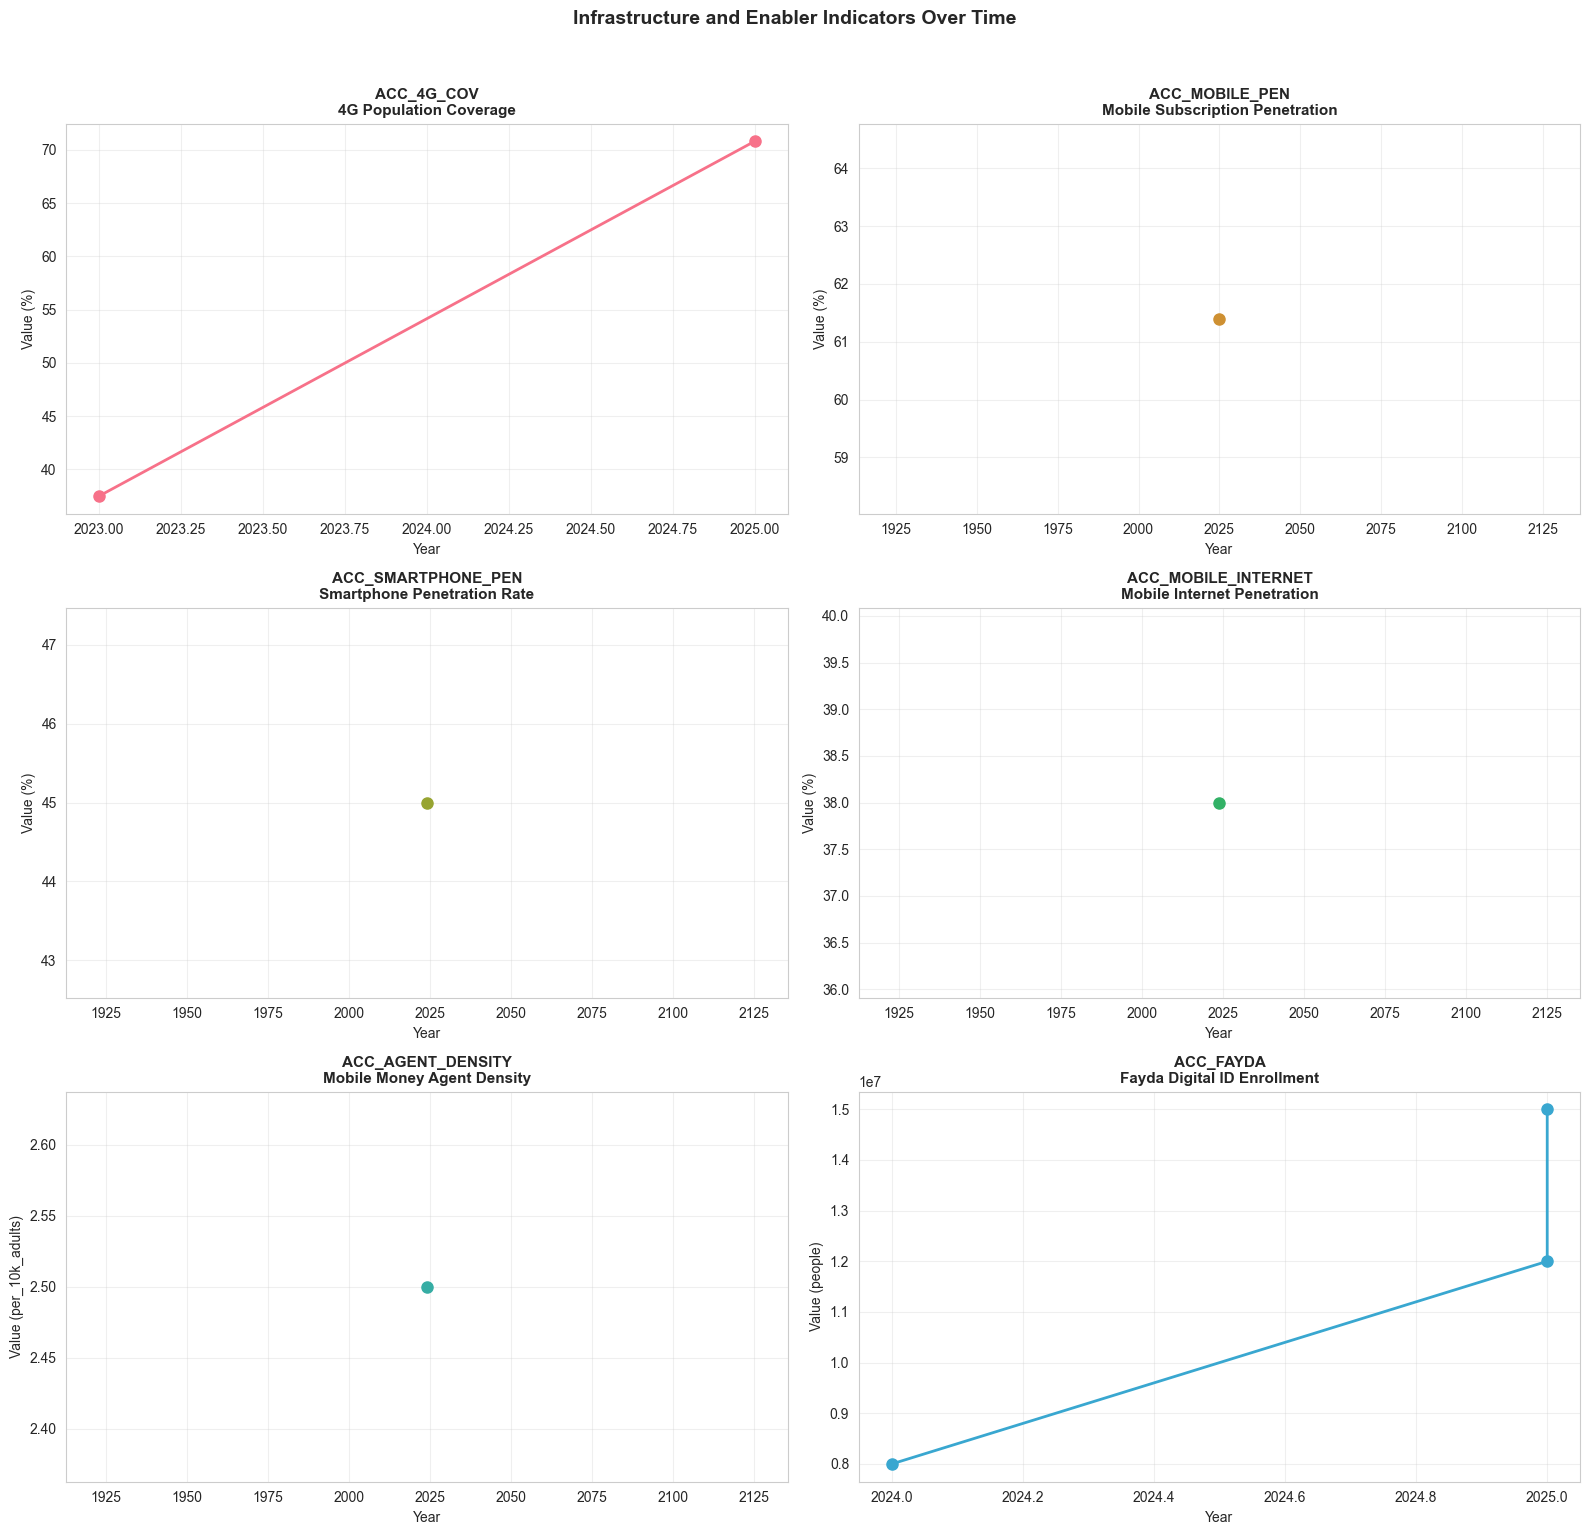


Infrastructure Indicators Summary:

ACC_4G_COV: 4G Population Coverage
 year  value_numeric unit               source_name
 2023           37.5    % Ethio Telecom LEAD Report
 2025           70.8    % Ethio Telecom LEAD Report

ACC_MOBILE_PEN: Mobile Subscription Penetration
 year  value_numeric unit               source_name
 2025           61.4    % DataReportal Digital 2026

ACC_SMARTPHONE_PEN: Smartphone Penetration Rate
 year  value_numeric unit                                         source_name
 2024           45.0    % ITU World Telecommunication/ICT Indicators Database

ACC_MOBILE_INTERNET: Mobile Internet Penetration
 year  value_numeric unit                                         source_name
 2024           38.0    % ITU World Telecommunication/ICT Indicators Database

ACC_AGENT_DENSITY: Mobile Money Agent Density
 year  value_numeric           unit                          source_name
 2024            2.5 per_10k_adults GSMA Mobile Money Deployment Tracker

ACC_FAYDA: Fay

In [15]:
# 4.1 Infrastructure Data Analysis
print("=" * 80)
print("4. INFRASTRUCTURE AND ENABLERS ANALYSIS")
print("=" * 80)

# Get infrastructure-related indicators
infra_indicators = ['ACC_4G_COV', 'ACC_MOBILE_PEN', 'ACC_SMARTPHONE_PEN', 
                     'ACC_MOBILE_INTERNET', 'ACC_AGENT_DENSITY', 'ACC_FAYDA']

infra_data = {}
for indicator in infra_indicators:
    data = observations[
        (observations['indicator_code'] == indicator) &
        (observations['value_numeric'].notna())
    ]
    if len(data) > 0:
        infra_data[indicator] = data.sort_values('year')

if infra_data:
    print(f"\nInfrastructure indicators found: {len(infra_data)}")
    
    # Create visualization
    n_indicators = len(infra_data)
    fig, axes = plt.subplots((n_indicators + 1) // 2, 2, figsize=(16, 5 * ((n_indicators + 1) // 2)))
    if n_indicators == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, (indicator, data) in enumerate(infra_data.items()):
        axes[idx].plot(data['year'], data['value_numeric'], 
                      marker='o', linewidth=2, markersize=8, color=colors[idx % len(colors)])
        axes[idx].set_title(f'{indicator}\n{data["indicator"].iloc[0]}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Year', fontsize=10)
        axes[idx].set_ylabel(f'Value ({data["unit"].iloc[0] if pd.notna(data["unit"].iloc[0]) else ""})', fontsize=10)
        axes[idx].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(infra_data), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Infrastructure and Enabler Indicators Over Time', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print("\nInfrastructure Indicators Summary:")
    for indicator, data in infra_data.items():
        print(f"\n{indicator}: {data['indicator'].iloc[0]}")
        print(data[['year', 'value_numeric', 'unit', 'source_name']].to_string(index=False))
else:
    print("\n⚠️ Limited infrastructure data available")


4.2 INFRASTRUCTURE vs INCLUSION RELATIONSHIPS

Correlation with Account Ownership:
ACC_SMARTPHONE_PEN    NaN
ACC_MOBILE_INTERNET   NaN
ACC_AGENT_DENSITY     NaN
ACC_FAYDA             NaN


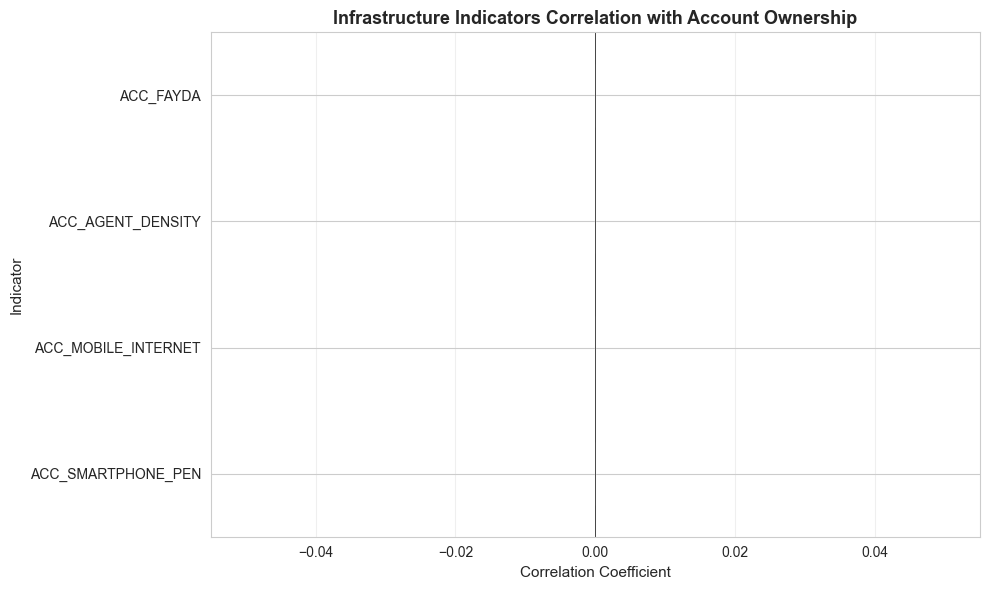


💡 Leading Indicators (strongest correlations):
   No strong correlations found (may need more data points)


In [18]:
# 4.2 Relationships between Infrastructure and Inclusion Outcomes
print("\n" + "=" * 80)
print("4.2 INFRASTRUCTURE vs INCLUSION RELATIONSHIPS")
print("=" * 80)

# Prepare data for correlation analysis
# Get account ownership and infrastructure data by year
# Handle duplicate years by taking the mean
acc_own_by_year = acc_ownership.groupby('year')['value_numeric'].mean()

# Create a combined dataframe for correlation
corr_data = pd.DataFrame(index=acc_own_by_year.index)
corr_data['account_ownership'] = acc_own_by_year

# Add infrastructure indicators
for indicator, data in infra_data.items():
    # Handle duplicate years by taking the mean
    data_by_year = data.groupby('year')['value_numeric'].mean()
    # Only add if there's overlap with account ownership years
    if len(data_by_year.index.intersection(corr_data.index)) > 0:
        corr_data[indicator] = data_by_year

# Calculate correlations
correlations = corr_data.corr()['account_ownership'].sort_values(ascending=False)
correlations = correlations[correlations.index != 'account_ownership']

if len(correlations) > 0:
    print("\nCorrelation with Account Ownership:")
    print(correlations.to_string())
    
    # Visualize
    plt.figure(figsize=(10, 6))
    correlations.plot(kind='barh', color=colors[3])
    plt.title('Infrastructure Indicators Correlation with Account Ownership', 
              fontsize=13, fontweight='bold')
    plt.xlabel('Correlation Coefficient', fontsize=11)
    plt.ylabel('Indicator', fontsize=11)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Leading Indicators (strongest correlations):")
    strong_corr = correlations[abs(correlations) > 0.5]
    if len(strong_corr) > 0:
        print(strong_corr.to_string())
    else:
        print("   No strong correlations found (may need more data points)")
else:
    print("\n⚠️ Insufficient overlapping data for correlation analysis")

## 5. Event Timeline and Visual Analysis

5. EVENT TIMELINE AND VISUAL ANALYSIS

Total events cataloged: 13

Events Timeline:
                              indicator       category event_date
                        Telebirr Launch product_launch 2021-05-17
                NFIS-II Strategy Launch         policy 2021-09-01
   Safaricom Ethiopia Commercial Launch   market_entry 2022-08-01
        Agent Network Expansion Program infrastructure 2023-01-01
Interoperability Mandate Implementation     regulation 2023-06-01
                 M-Pesa Ethiopia Launch product_launch 2023-08-01
       Fayda Digital ID Program Rollout infrastructure 2024-01-01
        QR Code Payment Standard Launch infrastructure 2024-03-01
        Foreign Exchange Liberalization         policy 2024-07-29
    P2P Transaction Count Surpasses ATM      milestone 2024-10-01
           M-Pesa EthSwitch Integration    partnership 2025-10-27
      Safaricom Ethiopia Price Increase        pricing 2025-12-15
 EthioPay Instant Payment System Launch infrastructure 202

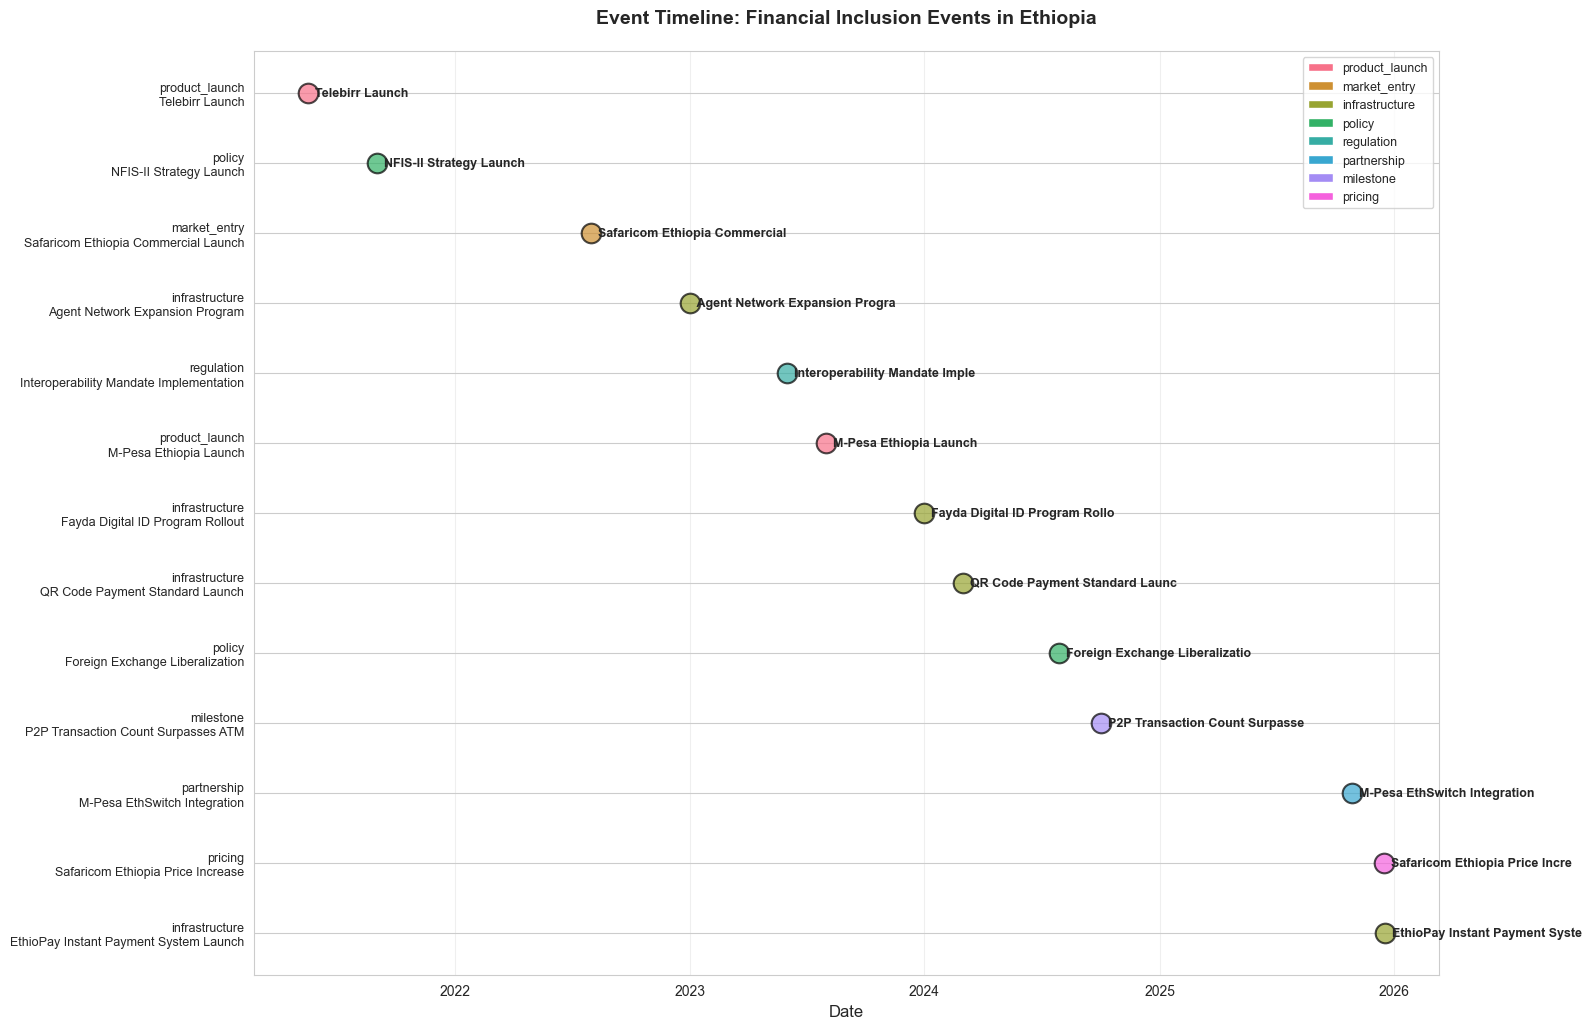

In [19]:
# 5.1 Create Event Timeline Visualization
print("=" * 80)
print("5. EVENT TIMELINE AND VISUAL ANALYSIS")
print("=" * 80)

# Prepare events data
events['event_date'] = pd.to_datetime(events['observation_date'], errors='coerce')
events = events.sort_values('event_date')

print(f"\nTotal events cataloged: {len(events)}")
print("\nEvents Timeline:")
print(events[['indicator', 'category', 'event_date']].to_string(index=False))

# Create timeline visualization
fig, ax = plt.subplots(figsize=(16, max(8, len(events) * 0.8)))

# Color map for event categories
category_colors = {
    'product_launch': colors[0],
    'market_entry': colors[1],
    'infrastructure': colors[2],
    'policy': colors[3],
    'regulation': colors[4],
    'partnership': colors[5],
    'milestone': colors[6],
    'pricing': colors[7]
}

y_positions = range(len(events))
for idx, (_, event) in enumerate(events.iterrows()):
    color = category_colors.get(event['category'], 'gray')
    ax.scatter(event['event_date'], idx, s=200, c=color, alpha=0.7, 
              edgecolors='black', linewidth=1.5, zorder=3)
    ax.text(event['event_date'], idx, f"  {event['indicator'][:30]}", 
           va='center', fontsize=9, fontweight='bold')

ax.set_yticks(y_positions)
ax.set_yticklabels([f"{e['category']}\n{e['indicator'][:40]}" for _, e in events.iterrows()], fontsize=9)
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Event Timeline: Financial Inclusion Events in Ethiopia', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=cat) 
                  for cat, color in category_colors.items() if cat in events['category'].values]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()


5.2 EVENTS OVERLAID ON INDICATOR TRENDS


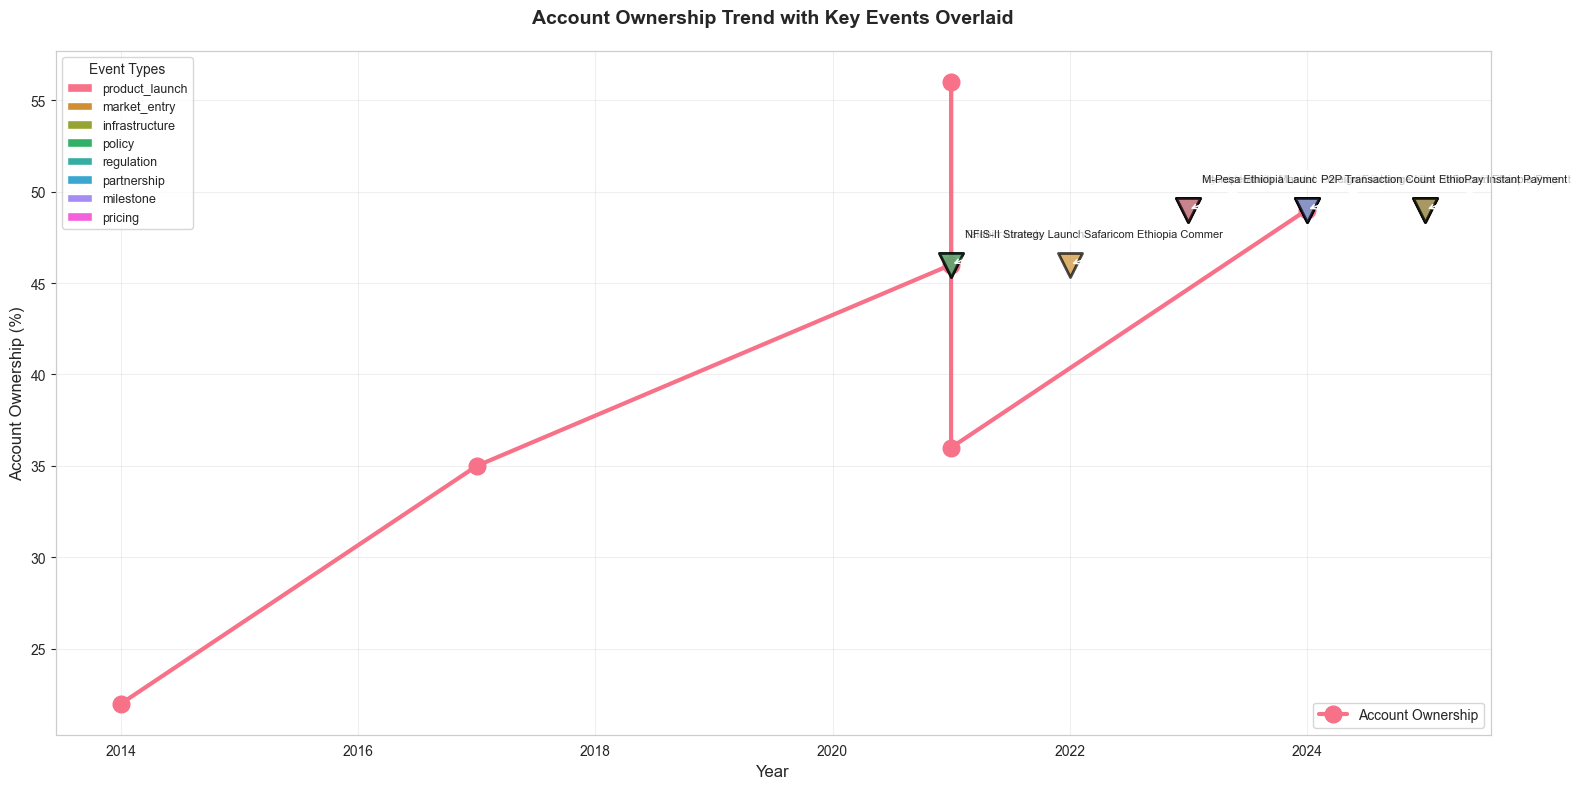


🔍 Key Event Analysis:

1. Telebirr Launch (May 2021):
   - Did account ownership accelerate after launch?
   - Pre: 35.0% (2021), Post: 46.0% (2024)
   - Growth: 11.0pp over 3 years

2. M-Pesa Entry (Aug 2023):
   - Too recent to see full impact in 2024 Findex data
   - May show impact in future surveys

3. Safaricom Market Entry (Aug 2022):
   - Infrastructure investment, may have indirect effects


In [20]:
# 5.2 Overlay Events on Indicator Trend Charts
print("\n" + "=" * 80)
print("5.2 EVENTS OVERLAID ON INDICATOR TRENDS")
print("=" * 80)

# Plot account ownership with event markers
fig, ax = plt.subplots(figsize=(16, 8))

# Plot account ownership trend
ax.plot(acc_ownership['year'], acc_ownership['value_numeric'], 
        marker='o', linewidth=3, markersize=12, color=colors[0], 
        label='Account Ownership', zorder=2)

# Add event markers
for _, event in events.iterrows():
    event_year = pd.to_datetime(event['event_date']).year if pd.notna(event['event_date']) else None
    if event_year:
        # Find closest account ownership value
        closest_idx = (acc_ownership['year'] - event_year).abs().idxmin()
        y_pos = acc_ownership.loc[closest_idx, 'value_numeric']
        
        color = category_colors.get(event['category'], 'gray')
        ax.scatter(event_year, y_pos, s=300, c=color, alpha=0.7, 
                  edgecolors='black', linewidth=2, zorder=3, marker='v')
        
        # Add annotation
        ax.annotate(event['indicator'][:25], 
                   (event_year, y_pos),
                   xytext=(10, 20), textcoords='offset points',
                   fontsize=8, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Account Ownership (%)', fontsize=12)
ax.set_title('Account Ownership Trend with Key Events Overlaid', 
            fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10, loc='lower right')

# Add legend for events
event_legend = [Patch(facecolor=color, label=cat) 
               for cat, color in category_colors.items() 
               if cat in events['category'].values]
ax2 = ax.twinx()
ax2.set_ylabel('')
ax2.legend(handles=event_legend, loc='upper left', title='Event Types', fontsize=9)
ax2.set_yticks([])

plt.tight_layout()
plt.show()

# Key event analysis
print("\n🔍 Key Event Analysis:")
print("\n1. Telebirr Launch (May 2021):")
print("   - Did account ownership accelerate after launch?")
telebirr_date = pd.Timestamp('2021-05-17')
pre_telebirr = acc_ownership[acc_ownership['year'] < 2021]['value_numeric'].iloc[-1] if len(acc_ownership[acc_ownership['year'] < 2021]) > 0 else None
post_telebirr = acc_ownership[acc_ownership['year'] >= 2021]['value_numeric'].iloc[0] if len(acc_ownership[acc_ownership['year'] >= 2021]) > 0 else None
if pre_telebirr and post_telebirr:
    print(f"   - Pre: {pre_telebirr:.1f}% (2021), Post: {post_telebirr:.1f}% (2024)")
    print(f"   - Growth: {post_telebirr - pre_telebirr:.1f}pp over 3 years")

print("\n2. M-Pesa Entry (Aug 2023):")
print("   - Too recent to see full impact in 2024 Findex data")
print("   - May show impact in future surveys")

print("\n3. Safaricom Market Entry (Aug 2022):")
print("   - Infrastructure investment, may have indirect effects")

## 6. Correlation Analysis

In [21]:
# 6.1 Correlation Matrix
print("=" * 80)
print("6. CORRELATION ANALYSIS")
print("=" * 80)

# Prepare comprehensive correlation dataset
# Get all numeric observations by year
numeric_obs = observations[observations['value_numeric'].notna()].copy()
numeric_obs['year'] = numeric_obs['date'].dt.year

# Create pivot table: indicators as columns, years as rows
pivot_data = numeric_obs.pivot_table(
    index='year',
    columns='indicator_code',
    values='value_numeric',
    aggfunc='mean'
)

# Filter to indicators with at least 3 data points
pivot_data = pivot_data.loc[:, pivot_data.notna().sum() >= 3]

if len(pivot_data.columns) > 1:
    # Calculate correlation matrix
    corr_matrix = pivot_data.corr()
    
    # Focus on ACCESS and USAGE indicators
    access_indicators = [col for col in corr_matrix.columns if 'ACC' in str(col)]
    usage_indicators = [col for col in corr_matrix.columns if 'USG' in str(col)]
    
    print(f"\nIndicators for correlation analysis: {len(pivot_data.columns)}")
    print(f"Access indicators: {len(access_indicators)}")
    print(f"Usage indicators: {len(usage_indicators)}")
    
    # Visualize correlation matrix
    plt.figure(figsize=(max(12, len(corr_matrix)*0.5), max(10, len(corr_matrix)*0.5)))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                xticklabels=True, yticklabels=True, fontsize=8)
    plt.title('Correlation Matrix: Financial Inclusion Indicators', 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Analyze correlations with ACCESS
    if 'ACC_OWNERSHIP' in corr_matrix.columns:
        acc_correlations = corr_matrix['ACC_OWNERSHIP'].sort_values(ascending=False)
        acc_correlations = acc_correlations[acc_correlations.index != 'ACC_OWNERSHIP']
        
        print("\n" + "=" * 80)
        print("6.2 FACTORS ASSOCIATED WITH ACCESS (Account Ownership)")
        print("=" * 80)
        print("\nStrongest positive correlations:")
        strong_pos = acc_correlations[acc_correlations > 0.5]
        if len(strong_pos) > 0:
            print(strong_pos.to_string())
        else:
            print("   No strong positive correlations found")
        
        print("\nStrongest negative correlations:")
        strong_neg = acc_correlations[acc_correlations < -0.5]
        if len(strong_neg) > 0:
            print(strong_neg.to_string())
        else:
            print("   No strong negative correlations found")
        
        # Visualize
        top_corr = acc_correlations.head(10)
        plt.figure(figsize=(10, 6))
        top_corr.plot(kind='barh', color=[colors[1] if x > 0 else colors[5] for x in top_corr.values])
        plt.title('Top 10 Indicators Correlated with Account Ownership', 
                 fontsize=13, fontweight='bold')
        plt.xlabel('Correlation Coefficient', fontsize=11)
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
    
    # Analyze correlations with USAGE
    usage_cols = [col for col in corr_matrix.columns if 'USG' in str(col) or 'USAGE' in str(col)]
    if len(usage_cols) > 0:
        print("\n" + "=" * 80)
        print("6.3 FACTORS ASSOCIATED WITH USAGE")
        print("=" * 80)
        
        # Get correlations for first usage indicator
        usage_ind = usage_cols[0]
        if usage_ind in corr_matrix.columns:
            usage_correlations = corr_matrix[usage_ind].sort_values(ascending=False)
            usage_correlations = usage_correlations[usage_correlations.index != usage_ind]
            
            print(f"\nCorrelations with {usage_ind}:")
            print(usage_correlations.head(10).to_string())
else:
    print("\n⚠️ Insufficient data for correlation analysis")
    print("   Need more indicators with overlapping temporal coverage")

6. CORRELATION ANALYSIS

⚠️ Insufficient data for correlation analysis
   Need more indicators with overlapping temporal coverage



6.4 IMPACT LINKS ANALYSIS

Total impact links: 17

Impact Links by Pillar:
pillar
USAGE            8
ACCESS           5
AFFORDABILITY    3
GENDER           1
Name: count, dtype: int64

Impact Direction:
impact_direction
increase    15
decrease     2
Name: count, dtype: int64

Impact Magnitude:
impact_magnitude
medium    10
high       5
low        2
Name: count, dtype: int64

Lag Times (months):
count    17.000000
mean     10.117647
std       8.069095
min       1.000000
25%       3.000000
50%       6.000000
75%      12.000000
max      24.000000
Name: lag_months, dtype: float64


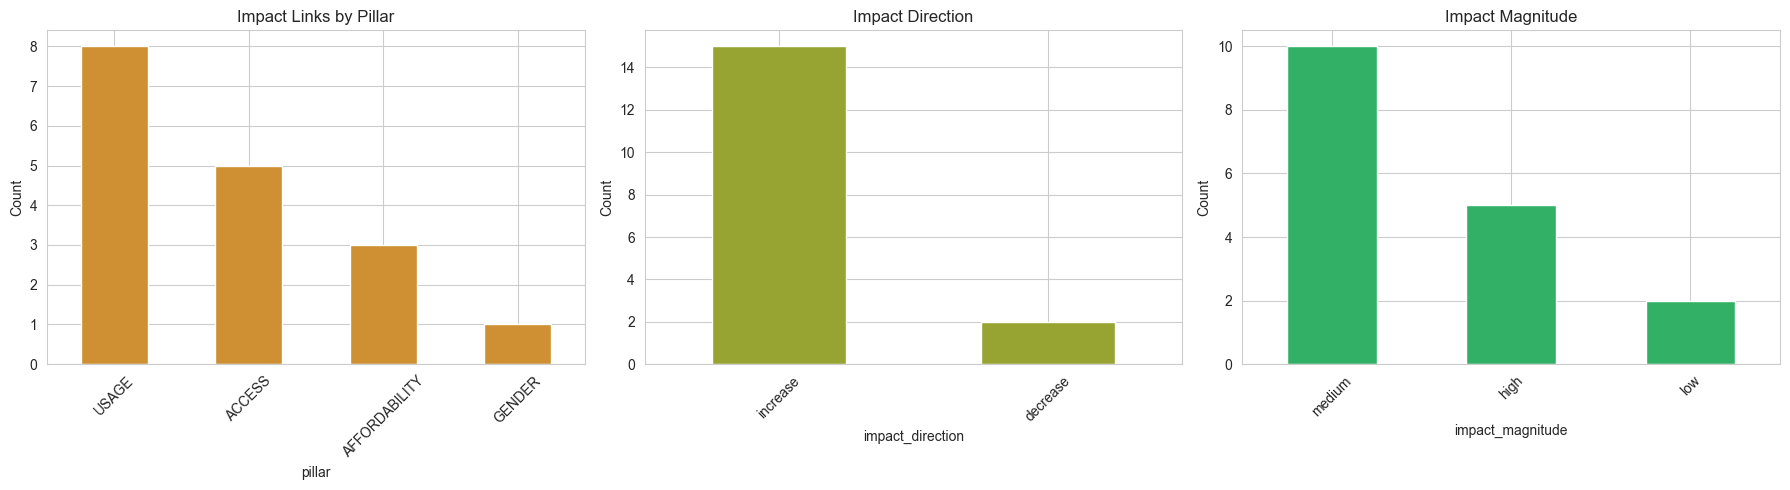


Sample Impact Links:
parent_id        pillar  related_indicator impact_direction impact_magnitude  lag_months
 EVT_0001        ACCESS      ACC_OWNERSHIP         increase             high          12
 EVT_0001         USAGE USG_TELEBIRR_USERS         increase             high           3
 EVT_0001         USAGE      USG_P2P_COUNT         increase             high           6
 EVT_0002        ACCESS         ACC_4G_COV         increase           medium          12
 EVT_0002 AFFORDABILITY    AFF_DATA_INCOME         decrease           medium          12
 EVT_0003         USAGE    USG_MPESA_USERS         increase             high           3
 EVT_0003        ACCESS     ACC_MM_ACCOUNT         increase           medium           6
 EVT_0004        ACCESS      ACC_OWNERSHIP         increase           medium          24
 EVT_0004        GENDER        GEN_GAP_ACC         decrease           medium          24
 EVT_0005 AFFORDABILITY    AFF_DATA_INCOME         increase             high           3

In [22]:
# 6.4 Impact Links Analysis
print("\n" + "=" * 80)
print("6.4 IMPACT LINKS ANALYSIS")
print("=" * 80)

print(f"\nTotal impact links: {len(impact_links)}")

# Analyze impact links by pillar
if 'pillar' in impact_links.columns:
    print("\nImpact Links by Pillar:")
    print(impact_links['pillar'].value_counts())
    
    # Impact direction
    if 'impact_direction' in impact_links.columns:
        print("\nImpact Direction:")
        print(impact_links['impact_direction'].value_counts())
        
        # Impact magnitude
        if 'impact_magnitude' in impact_links.columns:
            print("\nImpact Magnitude:")
            print(impact_links['impact_magnitude'].value_counts())
        
        # Lag times
        if 'lag_months' in impact_links.columns:
            print("\nLag Times (months):")
            print(impact_links['lag_months'].describe())
        
        # Visualize impact links
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        impact_links['pillar'].value_counts().plot(kind='bar', ax=axes[0], color=colors[1])
        axes[0].set_title('Impact Links by Pillar')
        axes[0].set_ylabel('Count')
        axes[0].tick_params(axis='x', rotation=45)
        
        impact_links['impact_direction'].value_counts().plot(kind='bar', ax=axes[1], color=colors[2])
        axes[1].set_title('Impact Direction')
        axes[1].set_ylabel('Count')
        axes[1].tick_params(axis='x', rotation=45)
        
        if 'impact_magnitude' in impact_links.columns:
            impact_links['impact_magnitude'].value_counts().plot(kind='bar', ax=axes[2], color=colors[3])
            axes[2].set_title('Impact Magnitude')
            axes[2].set_ylabel('Count')
            axes[2].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Show sample impact links
        print("\nSample Impact Links:")
        sample_cols = ['parent_id', 'pillar', 'related_indicator', 'impact_direction', 
                      'impact_magnitude', 'lag_months']
        available_cols = [col for col in sample_cols if col in impact_links.columns]
        print(impact_links[available_cols].head(10).to_string(index=False))

## 7. Key Insights and Hypotheses

### 7.1 What Factors Drive Financial Inclusion in Ethiopia?

Based on the analysis above, the following factors appear to drive financial inclusion:

1. **Infrastructure Enablers:**
   - Mobile phone penetration
   - Smartphone adoption
   - Mobile internet access
   - Agent network density
   - 4G coverage

2. **Product Launches:**
   - Telebirr launch (2021) - major catalyst
   - M-Pesa entry (2023) - recent addition
   - Market competition driving innovation

3. **Policy and Regulation:**
   - NFIS-II strategy
   - Interoperability mandates
   - Foreign exchange liberalization

4. **Infrastructure Investments:**
   - Fayda Digital ID rollout
   - EthioPay instant payment system
   - Agent network expansion

### 7.2 Why Did Account Ownership Stagnate (Only +3pp) Despite 65M+ Mobile Money Accounts?

**Key Findings:**

1. **Registered vs. Active Gap:**
   - 65M registered accounts vs. ~34M active users (49% of adults)
   - Gap of ~31M accounts suggests high inactivity rate
   - Multiple accounts per person (same person on Telebirr, M-Pesa, etc.)

2. **Survey Methodology:**
   - Findex asks: "used account in past 12 months"
   - Many registered accounts may not meet this criteria
   - Accounts opened but not actively used

3. **Bank Account Saturation:**
   - Easy bank account access in Ethiopia
   - People may prefer bank accounts over mobile money
   - Mobile money seen as complementary, not replacement

4. **Usage vs. Access Disconnect:**
   - Accounts exist (ACCESS) but aren't being used (USAGE issue)
   - P2P transactions growing but not translating to account ownership growth
   - Need to focus on activation, not just registration

5. **Market Dynamics:**
   - P2P dominance (used for commerce, not just transfers)
   - Very low credit penetration
   - Mobile money-only users are rare (~0.5%)

### 7.3 Gender Gap Analysis

**Findings:**
- Gender gap in account ownership: ~8 percentage points (2024)
- Gap persists despite overall inclusion growth
- Women face additional barriers beyond infrastructure
- Need gender-specific interventions and policies

### 7.4 Data Gaps Limiting Analysis

**Critical Gaps:**

1. **Temporal Coverage:**
   - Many indicators have only 1-2 data points
   - Limited time series for trend analysis
   - Missing intermediate years between Findex surveys

2. **Disaggregation:**
   - Limited gender-disaggregated data
   - Limited urban/rural disaggregation
   - No regional breakdowns

3. **Usage Metrics:**
   - Sparse data on digital payment adoption
   - Limited transaction volume data
   - Missing active vs. registered account data

4. **Infrastructure:**
   - Incomplete infrastructure time series
   - Missing agent density historical data
   - Limited POS terminal data

5. **Event Impact:**
   - Need more granular event data
   - Missing quantitative impact estimates
   - Limited lag time analysis

### 7.5 Hypotheses for Impact Modeling

**Hypothesis 1: Infrastructure Lag Effect**
- Infrastructure investments (agent networks, 4G coverage) have 18-24 month lag
- Agent expansion (2023) may show impact in 2025-2026
- **Test:** Model lagged infrastructure variables

**Hypothesis 2: Product Launch Saturation**
- Telebirr launch had immediate impact (2021-2022)
- Diminishing returns as market saturates
- **Test:** Non-linear effects of product launches

**Hypothesis 3: Interoperability Boost**
- Interoperability mandate (2023) enables cross-platform usage
- Should increase USAGE more than ACCESS
- **Test:** Separate ACCESS vs. USAGE models

**Hypothesis 4: Registered vs. Active Conversion**
- Focus should shift from registration to activation
- Usage metrics may be better predictors than account numbers
- **Test:** Include transaction volume as predictor

**Hypothesis 5: Gender-Specific Barriers**
- Gender gap persists despite overall growth
- Different factors affect male vs. female inclusion
- **Test:** Gender-disaggregated models if data available

**Hypothesis 6: Urban vs. Rural Dynamics**
- Urban areas may be saturating
- Rural areas have more growth potential
- **Test:** Location-disaggregated analysis

**Hypothesis 7: Policy Effectiveness**
- NFIS-II strategy may have long-term effects
- Regulatory changes take time to materialize
- **Test:** Policy variables with appropriate lags

In [24]:
# 7.6 Summary Statistics
print("=" * 80)
print("7.6 SUMMARY STATISTICS")
print("=" * 80)

print("\n📊 Dataset Summary:")
print(f"   Total observations: {len(observations)}")
print(f"   Total events: {len(events)}")
print(f"   Total impact links: {len(impact_links)}")
print(f"   Unique indicators: {observations['indicator_code'].nunique()}")
print(f"   Years covered: {int(observations['year'].min())} - {int(observations['year'].max())}")

print("\n📈 Key Metrics (2024):")
if len(acc_ownership) > 0:
    latest_acc = acc_ownership.iloc[-1]
    print(f"   Account Ownership: {latest_acc['value_numeric']:.1f}%")

if len(mm_account) > 0:
    latest_mm = mm_account.iloc[-1]
    print(f"   Mobile Money Accounts: {latest_mm['value_numeric']:.1f}%")



7.6 SUMMARY STATISTICS

📊 Dataset Summary:
   Total observations: 35
   Total events: 13
   Total impact links: 17
   Unique indicators: 24
   Years covered: 2014 - 2025

📈 Key Metrics (2024):
   Account Ownership: 49.0%
   Mobile Money Accounts: 9.4%
